In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

data = pd.read_csv('transaction_dataset.csv')

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   FLAG                                                  9841 non-null   int64  
 2   Avg min between sent tnx                              9841 non-null   float64
 3   Avg min between received tnx                          9841 non-null   float64
 4   Time Diff between first and last (Mins)               9841 non-null   float64
 5   Sent tnx                                              9841 non-null   int64  
 6   Received Tnx                                          9841 non-null   int64  
 7   Number of Created Contracts                           9841 non-null   int64  
 8   Unique Received From Addresses                        9841

In [2]:
print(data.columns)

Index(['Index', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx'

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Missing values - dropping

In [4]:
# dropping missing values
data.dropna(inplace=True)

In [5]:
# Defining features and target
y = data['FLAG']
X = data.drop(columns=['FLAG', 'Index'])

### Encoding

In [6]:
# Encoding non-numeric columns instead of dropping:
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

### Scaling

In [7]:
# Scaling features
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

In [8]:
# Splitting into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Model training

In [10]:
# Random forest
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
y_pred = random_forest_classifier.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nF1-Score:", f1_score(y_test, y_pred))
print("\nAUC-ROC Score:", roc_auc_score(y_test, random_forest_classifier.predict_proba(X_test)[:, 1]))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1527
           1       1.00      0.97      0.98       270

    accuracy                           1.00      1797
   macro avg       1.00      0.99      0.99      1797
weighted avg       1.00      1.00      1.00      1797


Confusion Matrix:
[[1527    0]
 [   8  262]]

F1-Score: 0.9849624060150376

AUC-ROC Score: 0.9999708942734482


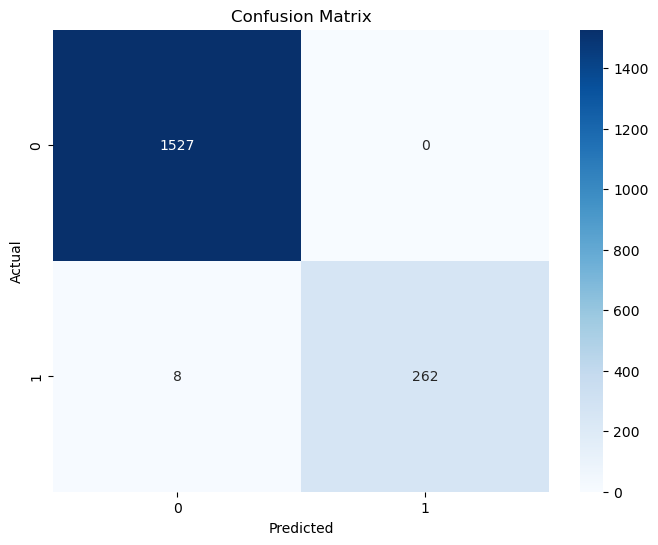

In [12]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

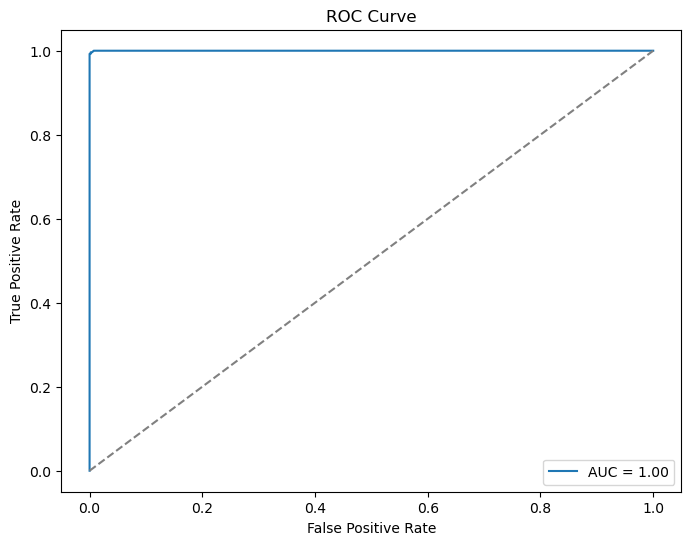

In [13]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for positive class
y_proba = random_forest_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [15]:

import joblib

joblib.dump(random_forest_classifier, "random_forest_model.pkl")


['random_forest_model.pkl']

In [22]:
# Using lightgbm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
}

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm = lgb.train(
    params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=5)]
)

print("Starting training...")
# train
gbm = lgb.train(
    params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=5)]
)

print("Saving model...")
# save model to file
gbm.save_model("model.txt")

print("Starting predicting...")
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"The RMSE of prediction is: {rmse_test}")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.103935	valid_0's l2: 0.0219859
Starting training...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.103935	valid_0's l2: 0.0219859
Saving model...
Starting predicting...
The RMSE of prediction is: 0.14827649430634932
